In [1]:
import sys
import cv2
import numpy as np
from itertools import product
from pathlib import Path
from typing import Tuple, List
from skimage.util import view_as_windows
class ImageAdapter:

    def __init__(self, 
                 img: np.ndarray, 
                 patch_size: int, 
                 overlap_ratio: float) -> None:
        """
        Initialize the ImageAdapter class. Adapt images to the U-net input and
        allow to stich them back together to the original shape.

        Args:
            img (np.ndarray): Input image array.
            patch_size (int): Width and height of square patches.
            overlap_ratio (float): Fraction of pixels to overlap.
        """
        self.img = img
        self.source_shape = img.shape
        self.patch_size = patch_size
        self.overlap_size = int(patch_size * overlap_ratio)

    def create_patches(self) -> np.ndarray:
        """
        Split the image into patches using view_as_windows.

        Returns:
            np.ndarray: Array of image patches.
        """

        step_size = (self.patch_size - self.overlap_size, self.patch_size - self.overlap_size)
        img = self.fit_image(self.img, step_size)
        image_patches = view_as_windows(img, (self.patch_size, self.patch_size), step_size)

        # Flatten into patches
        self.n_patches_w = image_patches.shape[1]
        self.n_patches_h = image_patches.shape[0]
        image_patches = image_patches.reshape(-1, self.patch_size, self.patch_size)

        return image_patches

    def stich_patches(self, image_patches: np.ndarray) -> np.ndarray:
        """
        Stitch the image patches back into a single image.

        Args:
            image_patches (np.ndarray): Array of image patches.

        Returns:
            np.ndarray: Reconstructed image array.
        """
        
        overlap_size = self.overlap_size
        
        reconstructed = np.zeros((self.n_patches_h * (self.patch_size - overlap_size) + self.overlap_size,
                                  self.n_patches_w * (self.patch_size - overlap_size) + self.overlap_size))
        reconstructed_slices = [np.zeros_like(reconstructed) for _ in range(len(image_patches))]


        idx_table = product(range(self.n_patches_h), range(self.n_patches_w))

        for n, (i, j) in enumerate(idx_table):
            patch = image_patches[n, :, :]
            h_idx = i * (self.patch_size - overlap_size)
            w_idx = j * (self.patch_size - overlap_size)
            reconstructed_slices[n][h_idx:h_idx+self.patch_size, w_idx:w_idx+self.patch_size] = patch

        reconstructed_slices=np.asarray(reconstructed_slices)
        reconstructed = np.max(reconstructed_slices, axis=0)

        # Crop the reconstructed image to the original size
        reconstructed = reconstructed[:self.source_shape[0], :self.source_shape[1]]

        return reconstructed

    def fit_image(self, img: np.ndarray, step_size: Tuple[int, int]) -> np.ndarray:
        """
        Pad the image to ensure it is divisible by the effective patch size.

        Args:
            img (np.ndarray): Input image array.
            step_size (Tuple[int, int]): Step size for the sliding window.

        Returns:
            np.ndarray: Padded image array.
        """
        # Calculate the padding dims
        remainder_h = img.shape[0] % step_size[0]
        remainder_w = img.shape[1] % step_size[1]

        pad_h = 2*step_size[0] - remainder_h if remainder_h else 0
        pad_w = 2*step_size[1] - remainder_w if remainder_w else 0

        # Pad the image
        img = np.pad(img, ((0, pad_h), (0, pad_w)), 
                     mode='symmetric')

        return img
    
    def clear_background(self, sigma_r=25, method='divide', convert_32=True):
        
        # Input checks
        img = self.img.copy()

        if img.ndim != 2:
            raise ValueError("Input image must be 2D")
        if convert_32:
            img = img.astype(np.float32)
        def round_to_odd(number):
            return int(number) if number % 2 == 1 else int(number) + 1
        
        # Gaussian blur
        sigma_r=round_to_odd(sigma_r)
        gaussian_blur = cv2.GaussianBlur(img, (sigma_r, sigma_r), 0)

        # Background remove
        if method == 'subtract':
            background_removed = cv2.subtract(img, gaussian_blur)
        elif method == 'divide':
            background_removed = cv2.divide(img, gaussian_blur)
        else:
            raise ValueError("Invalid method. Choose either 'subtract' or 'divide'")
        
        self.img = background_removed

In [57]:
def normalize_percentile(x, pmin=1, pmax=99.8, clip=False, dtype=np.float32):
    """
    Percentile-based image normalization.

    Args:
        x (numpy.ndarray): Input array.
        pmin (float): Lower percentile value (default: 1).
        pmax (float): Upper percentile value (default: 99.8).
        clip (bool): Whether to clip the output values to the range [0, 1] (default: False).
        dtype (numpy.dtype): Output data type (default: np.float32).

    Returns:
        numpy.ndarray: Normalized array.
    """

    x = x.astype(dtype, copy=False)
    mi = np.percentile(x, pmin)
    ma = np.percentile(x, pmax)
    eps = np.finfo(dtype).eps  # Get the smallest positive value for the data type

    x = (x - mi) / (ma - mi + eps)

    if clip:
        x = np.clip(x, 0, 1)

    return x

In [2]:
import tifffile

img = tifffile.imread('../data/train/source/mabs_img_1.tif')


In [52]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=1, out_channels=1, features=[64, 128, 256, 512], init_features=64, pooling_steps=4
    ):
        super(UNET, self).__init__()

        if features == None:        
            features = [2**i for i in range(pooling_steps) if 2**i >= init_features]
        else:
            features = features
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)


    def load_weights(self, weights_path):
        """
        Load weights from a previously trained model.

        Args:
            weights_path (str): Path to the weights file.
        """
        self.load_state_dict(torch.load(weights_path))


    @classmethod
    def from_pretrained(cls, weights_path, **kwargs):
        """
        Create a UNet model and initialize it with pretrained weights.

        Args:
            weights_path (str): Path to the pretrained weights file.
            **kwargs: Additional arguments to pass to the constructor.

        Returns:
            UNet: Initialized UNet model with pretrained weights.
        """
        model = cls(**kwargs)
        model.load_weights(weights_path)
        return model


    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        
#        x = torch.sigmoid(x)

        return self.final_conv(x)

In [53]:
import torch

model_path = "../data/models/unet_model_test_1_best_model.pth"
model = torch.load(model_path)

model = UNET()


# Load the state dictionary into the model
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [54]:
import torch
import torchvision.transforms as transforms


device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Chop the image into tiles
adapter = ImageAdapter(img, patch_size=256, overlap_ratio=0.0)
#adapter.clear_background()
image_patches = adapter.create_patches()
normalized_images = np.empty_like(image_patches, dtype=np.float32)

for i in range(image_patches.shape[0]):
    normalized_images[i] = normalize_percentile(image_patches[i])
image_patches=normalized_images
# Transform the image patches into tensors
transform = transforms.ToTensor()
tensor_patches = [transform(patch) for patch in image_patches]

# Convert the tensor patches into a batch tensor
batch_tensor = torch.stack(tensor_patches)

# Move to the device and predict
batch_tensor = batch_tensor.to(device)
model = model.to(device)

with torch.no_grad():
    predictions = model(batch_tensor)

# Convert the predictions back to numpy array
predictions = predictions.cpu()

# Stitch back the image
reconstructed_image = adapter.stich_patches(predictions)


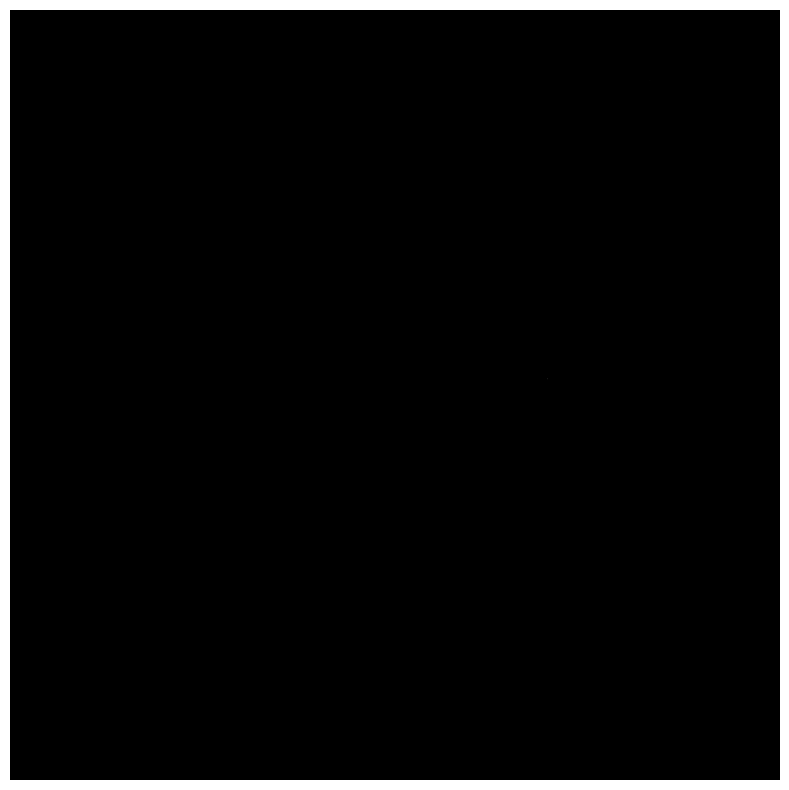

In [55]:
import matplotlib.pyplot as plt

# Create a figure with a specific size (width, height)
fig = plt.figure(figsize=(12, 8))  # Adjust the width and height as needed

plt.imshow(2**reconstructed_image, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

In [56]:
reconstructed_image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
reconstructed_image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])